# Simulation of soft computing course's project
#### Author: Mahdi Tanbakuchi             


<b> First required libraries are imported to the workspace </b>

In [3]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from itertools import permutations

<i> Now lets define the model to generate our data which can be later used for evaluating the idea proposed in the abstract</i><br>
Below the Fr represents the acceptable frequnecies for the normal case while the Fw is representetive for the abnormal case. scale is used to generate samples from the frequency ranges randomly

In [29]:
random.seed(0)
Fr = np.linspace(0,7,30)
Fr = np.concatenate((Fr,np.linspace(11,15,30)))
Fw = np.linspace(8,10,30)
Fr = np.random.permutation(Fr)
Fw = np.random.permutation(Fw)
scale = np.linspace(1,100,100)
scale = np.random.permutation(scale)

Now lets define experimental settings:


In [30]:
fs = 32       # in hertz    
duration=8   # in seconds
ch = 8       # Number of channels

Now that all the ingredients of the generator is made ready it is time to define the generator itself: <br>
The generator works as follows:
1. uses cosine function with the given frequency 
2. uses the wegith to superpose all the given frequencies 
<br>

The sampling frequency should also be given to the code (fs=32 hz by default)

In [31]:
def datagen(freq,coef,fs=32,duration=8):    
    t = np.arange(0,duration,1/fs)
    y = np.zeros(t.shape)
    if(np.linalg.norm(coef)!=1):
        coefnorm = coef/np.linalg.norm(coef)
    for i,j in zip(freq,coefnorm):
        y+=j*np.cos(2*np.pi*i*t)
    return y
        
    

Now parameter selection must be done in order to simulate the data for evaluation.<br> 
Here the following assumtions are made:
1. Only 5 components for each signal are used no more and no less
2. The two scenarios are assumed to be destinguishable in frequency bands 
3. The whole dataset size is set to 10000
4. the class in the training data set is imbalanced as is the case in real scenarios (80% normal and 20% abnormal case)

In [32]:
N = 5 
datasetsize = 10000
clr = 0.2
t = np.arange(0,duration,1/fs)
Frd = permutations(Fr,N)
Fwd = permutations(Fw,N)
scale1=permutations(scale,N)
scale = np.random.permutation(scale)
scale2=permutations(scale,N)
posdatasize = np.int32(datasetsize*(1-clr))
negdatasize = np.int32(datasetsize*clr)
posdata = []
negdata = []
for i in range(posdatasize):
    posdata.append(datagen(next(Frd),next(scale1)))
for i in range(negdatasize):
    negdata.append(datagen(next(Fwd),next(scale2)))


Let's see one of our subject samples (one channel of a subject) 

Text(0.5, 1.0, 'Abnormal case')

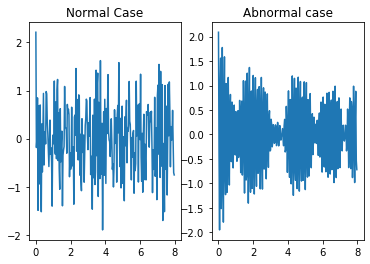

In [33]:
a1 = plt.subplot(121)
plt.plot(t,posdata[0])
a1.set_title("Normal Case")
a2 = plt.subplot(122)
plt.plot(t,negdata[0])
a2.set_title("Abnormal case")


In order to simulate wake labelling procedure as that happens in the real scenarios, we use the data produced in the previous stpes and sample from each ch times to obtain a ch-channel EEG signal sample data of duration length. Samples having at least one data from negdata are considered as abnormal case in the new training dataset. <br>
Below the normal EEG data is produced.

In [34]:
weakpositer = permutations(posdata,ch) 
posdataweak = np.zeros((posdatasize,ch,*t.shape))
classid = np.zeros((posdatasize))
for i in range(posdatasize):
    posdataweak[i]=np.array(next(weakpositer))

Below the abnormal EEG data is produced. First we decide how many channels are consistent with abnormal conditions afterwards we decide on which channel the abnormal EEG sample signal is to be appeared.

In [35]:
nums = random.choices(range(1,4),k=negdatasize)
positions = [random.sample(range(0,8),k=i) for i in nums]
posdata2 = iter(np.random.permutation(posdata))
negdata2 = iter(np.random.permutation(negdata))
negdataweak=[]
negdata3=np.zeros((negdatasize,ch,*t.shape))
classid = np.concatenate((classid,np.ones((negdatasize))))
index = 0
w0 = 1/posdatasize
w1 = 1/negdatasize
for pos in positions:
    for i in range(8):
        if(i in pos):
            try:
                negdata3[index,i,:] = next(negdata2)
            except StopIteration:
                negdata2 = iter(np.random.permutation(negdata))
                negdata3[index,i,:] = next(negdata2)
        else:
            try:
                negdata3[index,i,:] = next(posdata2)
            except StopIteration:
                posdata2 = iter(np.random.permutation(posdata))
                negdata3[index,i,:] = next(posdata2)
    index+=1
            
negdataweak = negdata3
datasetweak = np.concatenate((posdataweak,negdataweak))
datasetweak = np.expand_dims(datasetweak,-1)

Now we have produced the synthetic data conforming with the weak labels as that mentioned in the article; its time to train the proposed deep FCN with the procedure outlined in the paper. 

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [28]:
dummy = np.expand_dims(posdataweak,-1)
input_shape = dummy.shape[1:]

model = keras.Sequential(
    [
        # Feature extraction block
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.BatchNormalization(),
        layers.AveragePooling2D(pool_size=(1,4),strides=(1,3)),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.BatchNormalization(),
        layers.AveragePooling2D(pool_size=(1,4),strides=(1,3)),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.BatchNormalization(),
        layers.AveragePooling2D(pool_size=(1,4),strides=(1,3)),
        # Classification Block
        layers.Conv2D(2, kernel_size=(1,3), activation="relu"),
        layers.AveragePooling2D(pool_size=(1,4),strides=(1,3)),
        layers.MaxPooling2D(pool_size=(ch,1)),
        layers.Flatten(),
        layers.Softmax()
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.save("Raw_Model")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 8, 254, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 252, 32)        3104      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 250, 32)        3104      
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 250, 32)        128       
_________________________________________________________________
average_pooling2d_4 (Average (None, 8, 83, 32)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 81, 32)         3104      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 79, 32)        

<b>Now that the model is created it should be trained using the training data</b>

In [48]:
batch_size = 300
epochs = 1500
num_classes = 2
model = keras.models.load_model("Raw_Model")
ylabel = keras.utils.to_categorical(classid, num_classes)
X_train,X_test,Y_train,Y_test = train_test_split(datasetweak,ylabel,test_size = 0.2 , random_state=2)
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.9, nesterov=True, name="SGD"
)
model.compile(loss="binary_crossentropy",optimizer=sgd,metrics=["accuracy","AUC"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

class_weight = {0: w0, 1: w1}
weaklabel = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=[callback],class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 7200 samples, validate on 800 samples
Epoch 1/1500
7200/7200 [==============================] - 90s 12ms/sample - loss: 1.4985e-04 - accuracy: 0.2221 - AUC: 0.2446 - val_loss: 1.3213e-04 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 2/1500
7200/7200 [==============================] - 87s 12ms/sample - loss: 1.4769e-04 - accuracy: 0.2249 - AUC: 0.2599 - val_loss: 1.3213e-04 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 3/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 1.4523e-04 - accuracy: 0.2304 - AUC: 0.2780 - val_loss: 1.3213e-04 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 4/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 1.4269e-04 - accuracy: 0.2346 - AUC: 0.2960 - val_loss: 1.3213e-04 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 5/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 1.4046e-04 - accuracy: 0.2401 - AUC: 0.3149 - val_loss: 1.321

Epoch 43/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 8.9195e-05 - accuracy: 0.9011 - AUC: 0.9281 - val_loss: 8.6447e-05 - val_accuracy: 0.9025 - val_AUC: 0.9391
Epoch 44/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 8.8402e-05 - accuracy: 0.9033 - AUC: 0.9288 - val_loss: 8.5472e-05 - val_accuracy: 0.9038 - val_AUC: 0.9398
Epoch 45/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 8.7310e-05 - accuracy: 0.9051 - AUC: 0.9320 - val_loss: 8.4532e-05 - val_accuracy: 0.9038 - val_AUC: 0.9413
Epoch 46/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 8.6253e-05 - accuracy: 0.9075 - AUC: 0.9345 - val_loss: 8.3620e-05 - val_accuracy: 0.9050 - val_AUC: 0.9442
Epoch 47/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 8.5332e-05 - accuracy: 0.9096 - AUC: 0.9374 - val_loss: 8.2732e-05 - val_accuracy: 0.9038 - val_AUC: 0.9448
Epoch 48/1500
7200/7200 [====================

Epoch 86/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 5.9829e-05 - accuracy: 0.9594 - AUC: 0.9788 - val_loss: 5.9066e-05 - val_accuracy: 0.9600 - val_AUC: 0.9844
Epoch 87/1500
7200/7200 [==============================] - 84s 12ms/sample - loss: 5.9304e-05 - accuracy: 0.9594 - AUC: 0.9793 - val_loss: 5.8643e-05 - val_accuracy: 0.9588 - val_AUC: 0.9846
Epoch 88/1500
7200/7200 [==============================] - 84s 12ms/sample - loss: 5.9033e-05 - accuracy: 0.9596 - AUC: 0.9791 - val_loss: 5.8233e-05 - val_accuracy: 0.9600 - val_AUC: 0.9848
Epoch 89/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 5.8664e-05 - accuracy: 0.9599 - AUC: 0.9801 - val_loss: 5.7832e-05 - val_accuracy: 0.9625 - val_AUC: 0.9850
Epoch 90/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 5.8258e-05 - accuracy: 0.9615 - AUC: 0.9800 - val_loss: 5.7444e-05 - val_accuracy: 0.9650 - val_AUC: 0.9851
Epoch 91/1500
7200/7200 [====================

In [174]:
model.save("Unsorted_dataset")

INFO:tensorflow:Assets written to: Unsorted_dataset\assets


In [128]:
# posdataweak = np.array(posdataweak)
# negdataweakk = np.array(negdataweak)
# np.all(negdataweak[1]==negdataweak[10])
# np.all(posdataweak[2]==posdataweak[2])
# negdataweak
# posdataweak
input_shape

(8, 256)

## Test section 

In [122]:
class myclass:
    def __init__(self,a=10,b=5):
        self.a= a
        self.b = b
    def __call__(self):
        return self.a+self.b
        
a = myclass(2)
a()

7

In [79]:
a = np.ones((1,3))
b = np.ones((3,))*2
c = np.ones((3,))*3
d = [a,b,c]
dd = np.array(d)
a
np.all()

array([[1., 1., 1.]])

In [65]:
a=np.array([[1,2],[2,3],[3,4]])
print(a)
print(a.shape)
a=np.expand_dims(a,-1)
print(a)
print(a.shape)
# input_shape[::-1]
# np.expand_dims()
dummy.shape
# yy = keras.utils.to_categorical([1,0,1,1,0,0],num_classes=2)
# yy
Y_train.sum(0)


[[1 2]
 [2 3]
 [3 4]]
(3, 2)
[[[1]
  [2]]

 [[2]
  [3]]

 [[3]
  [4]]]
(3, 2, 1)


array([6405., 1595.], dtype=float32)

In [80]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
freq = ctrl.Antecedent(np.arange(0, 16, 1/100), 'freq')
Power = ctrl.Antecedent(np.arange(0,100,1/10),"Power")
Siezure=ctrl.Consequent(np.arange(0, 2, 1/100), 'Siezure')

freq["Low"] = fuzz.gaussmf(freq.universe,0,5)
freq["Mid"] = fuzz.gaussmf(freq.universe,9,0.5)
freq["High"] = fuzz.gaussmf(freq.universe,15,2.5)

Power["lims"] = fuzz.trapmf(Power.universe,[0,10,100,100])

Siezure["Low"] = fuzz.gaussmf(Siezure.universe,0,0.1)
Siezure["High"] = fuzz.gaussmf(Siezure.universe,1,0.1)
# Auto-membership function population is possible with .automf(3, 5, or 7)
# quality.automf(3)
# service.automf(3)

# # Custom membership functions can be built interactively with a familiar,
# # Pythonic API
# tip['low'] = fuzz.trimf(tip.universe, [0, 0, 13])
# tip['medium'] = fuzz.trimf(tip.universe, [0, 13, 25])
# tip['high'] = fuzz.trimf(tip.universe, [13, 25, 25])

In [82]:
rule1 = ctrl.Rule(freq['Low'] | freq['High'] & Power['lims'],Siezure['Low'])
rule2 = ctrl.Rule(freq['Mid'] & Power['lims'], Siezure['High'])
Siezureness_ctrl = ctrl.ControlSystem([rule1,rule2])
Siezureness = ctrl.ControlSystemSimulation(Siezureness_ctrl)
Siezureness.inputs({'freq':8,'Power':.1})
Siezureness.compute()
print(Siezureness.output['Siezure'])

0.20058641842697342


C:\eng_softs\Anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


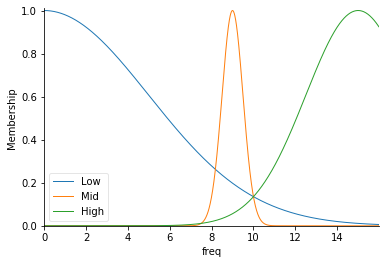

In [33]:
freq.view()

C:\eng_softs\Anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


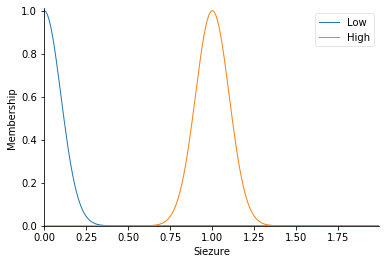

In [34]:
ax = Siezure.view()


C:\eng_softs\Anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


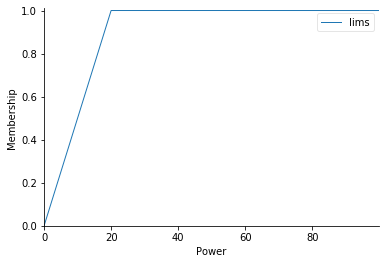

In [75]:
Power.view()

Now with the defined fuzzy rules we order the channels of the EEG based on their siezureness values. The following function takes as input a ch-channel EEG signal with the corrseponding fs and reorder its channel based on the siezureness

In [202]:
def sortdata(EEGdata,fs):
    siezuremeasure = np.zeros((EEGdata.shape[0]))
    sortedEEGdata = np.zeros(EEGdata.shape)    
    for k in range(EEGdata.shape[0]):
        fftdata = np.fft.fft(EEGdata[k,:])
        for i in range(int(fftdata.shape[0]/2)):
            Siezureness.inputs({'freq':i*fs/fftdata.shape[0],'Power':np.abs(fftdata[i])})
            Siezureness.compute()
            siezuremeasure[k] += Siezureness.output['Siezure']>0.8
    sort = np.sort(siezuremeasure)[::-1]    
    for k in range(sort.shape[0]):
        h = sort[k]==siezuremeasure        
        sortedEEGdata[k,:] = EEGdata[np.where(h)[0][0],:]
    return sortedEEGdata
def sortdataset(dataset,fs):
    sorteddataset = np.zeros(dataset.shape)
    for i in range(dataset.shape[0]):
        sorteddataset[i] = sortdata(dataset[i],fs)
    return sorteddataset

Now lets reorder all the training dataset based on their seizureness values using the function defined above

In [203]:
orderdposdataweak = sortdataset(posdataweak,fs)

In [5]:
import pickle

In [153]:
with open("posdatasetsorted","wb") as file:
    pickle.dump(orderdposdataweak,file)


In [25]:
with open("posdatasetsorted","rb") as file:
    orderdposdataweak = pickle.load(file) 

Now let's check the model on this ordered dataset.

In [150]:
datasetweak.shape
ylabel.shape
orderdposdataweak.shape

(8000, 8, 256)

In [151]:
orederednegdataweak = sortdataset(negdataweak,fs)

In [155]:
with open("negdatasetsorted","wb") as file:
    pickle.dump(orederednegdataweak,file)

In [26]:
with open("negdatasetsorted","rb") as file:
    orederednegdataweak = pickle.load(file)
# negdatass == orederednegdataweak

In [27]:
datasetweakordered = np.concatenate((orderdposdataweak,orederednegdataweak))
datasetweakordered = np.expand_dims(datasetweakordered,-1)
datasetweakordered.shape

(10000, 8, 256, 1)

In [36]:
batch_size = 300
epochs = 1500
num_classes = 2
model = keras.models.load_model("Raw_Model")
ylabel = keras.utils.to_categorical(classid, num_classes)
X_train,X_test,Y_train,Y_test = train_test_split(datasetweakordered, ylabel,test_size = 0.2 , random_state=2)
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.9, nesterov=True, name="SGD"
)
model.compile(loss="binary_crossentropy",optimizer=sgd,metrics=["accuracy","AUC"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

class_weight = {0: w0, 1: w1}
fuzzyordered = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=[callback],class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 7200 samples, validate on 800 samples
Epoch 1/1500
7200/7200 [==============================] - 89s 12ms/sample - loss: 1.7050e-04 - accuracy: 0.0386 - AUC: 0.0383


KeyboardInterrupt: 

In [176]:
model.save("sorteddataset")

INFO:tensorflow:Assets written to: sorteddataset\assets


In [38]:
# nums = random.choices(range(1,4),k=negdatasize)
# positions = [random.sample(range(0,8),k=i) for i in nums]
# posdata2 = iter(np.random.permutation(posdata))
# negdata2 = iter(np.random.permutation(negdata))
# negdataweak=[]
negdata3sorted=np.zeros((negdatasize,ch,*t.shape))
# classid = np.concatenate((classid,np.ones((negdatasize))))
index = 0
w0 = 1/posdatasize
w1 = 1/negdatasize
for pos in positions:
    num = 0
    for p in pos:
        try:
            negdata3sorted[index,num,:] = next(negdata2)
            num+=1
        except:
            negdata2 = iter(np.random.permutation(negdata))
            negdata3sorted[index,num,:] = next(negdata2)
            num+=1
    try:
        negdata3sorted[index,num,:] = next(posdata2)
        num+=1
    except:
        posdata2 = iter(np.random.permutation(posdata))
        negdata3sorted[index,num,:] = next(posdata2)
        num+=1
    index+=1
#     for i in range(8):
#         if(i in pos):
#             try:
#                 negdata3[index,i,:] = next(negdata2)
#             except StopIteration:
#                 negdata2 = iter(np.random.permutation(negdata))
#                 negdata3[index,i,:] = next(negdata2)
#         else:
#             try:
#                 negdata3[index,i,:] = next(posdata2)
#             except StopIteration:
#                 posdata2 = iter(np.random.permutation(posdata))
#                 negdata3[index,i,:] = next(posdata2)
#     index+=1

sorteddataset= np.expand_dims(np.concatenate((posdataweak,negdata3sorted)),-1)
sorteddataset.shape


(10000, 8, 256, 1)

In [39]:
'negdatasetsorted' in dir()

False

In [51]:
batch_size = 300
epochs = 1500
num_classes = 2
model = keras.models.load_model("Raw_Model")
ylabel = keras.utils.to_categorical(classid, num_classes)
X_train,X_test,Y_train,Y_test = train_test_split(sorteddataset, ylabel,test_size = 0.2 , random_state=2)
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.9, nesterov=True, name="SGD"
)
model.compile(loss="binary_crossentropy",optimizer=sgd,metrics=["accuracy","AUC"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

class_weight = {0: w0, 1: w1}
sortedmanual = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=[callback],class_weight=class_weight)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 7200 samples, validate on 800 samples
Epoch 1/1500
7200/7200 [==============================] - 88s 12ms/sample - loss: 1.6034e-04 - accuracy: 0.1776 - AUC: 0.1753 - val_loss: 1.3213e-04 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 2/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 1.5757e-04 - accuracy: 0.1807 - AUC: 0.1857 - val_loss: 1.3213e-04 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 3/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 1.5450e-04 - accuracy: 0.1864 - AUC: 0.1983 - val_loss: 1.3213e-04 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 4/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 1.5257e-04 - accuracy: 0.1875 - AUC: 0.2064 - val_loss: 1.3213e-04 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 5/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 1.5010e-04 - accuracy: 0.1907 - AUC: 0.2177 - val_loss: 1.321

Epoch 43/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 1.0208e-04 - accuracy: 0.5643 - AUC: 0.6067 - val_loss: 9.8557e-05 - val_accuracy: 0.8425 - val_AUC: 0.7908
Epoch 44/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 1.0090e-04 - accuracy: 0.7611 - AUC: 0.7019 - val_loss: 9.7811e-05 - val_accuracy: 0.8450 - val_AUC: 0.7944
Epoch 45/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 1.0001e-04 - accuracy: 0.7829 - AUC: 0.7546 - val_loss: 9.7042e-05 - val_accuracy: 0.8450 - val_AUC: 0.8033
Epoch 46/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 9.9220e-05 - accuracy: 0.7654 - AUC: 0.7368 - val_loss: 9.6280e-05 - val_accuracy: 0.8475 - val_AUC: 0.8071
Epoch 47/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 9.8274e-05 - accuracy: 0.8336 - AUC: 0.7796 - val_loss: 9.5511e-05 - val_accuracy: 0.8512 - val_AUC: 0.8184
Epoch 48/1500
7200/7200 [====================

Epoch 86/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 7.4004e-05 - accuracy: 0.9140 - AUC: 0.9377 - val_loss: 7.2567e-05 - val_accuracy: 0.9237 - val_AUC: 0.9355
Epoch 87/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 7.4301e-05 - accuracy: 0.9133 - AUC: 0.9365 - val_loss: 7.2168e-05 - val_accuracy: 0.9250 - val_AUC: 0.9373
Epoch 88/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 7.3389e-05 - accuracy: 0.9172 - AUC: 0.9406 - val_loss: 7.1771e-05 - val_accuracy: 0.9250 - val_AUC: 0.9376
Epoch 89/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 7.2696e-05 - accuracy: 0.9186 - AUC: 0.9433 - val_loss: 7.1378e-05 - val_accuracy: 0.9262 - val_AUC: 0.9379
Epoch 90/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 7.2895e-05 - accuracy: 0.9176 - AUC: 0.9418 - val_loss: 7.0998e-05 - val_accuracy: 0.9287 - val_AUC: 0.9420
Epoch 91/1500
7200/7200 [====================

Epoch 129/1500
7200/7200 [==============================] - 84s 12ms/sample - loss: 5.4513e-05 - accuracy: 0.9632 - AUC: 0.9844 - val_loss: 5.3632e-05 - val_accuracy: 0.9600 - val_AUC: 0.9912
Epoch 130/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 5.4746e-05 - accuracy: 0.9629 - AUC: 0.9846 - val_loss: 5.3264e-05 - val_accuracy: 0.9613 - val_AUC: 0.9913
Epoch 131/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 5.4306e-05 - accuracy: 0.9649 - AUC: 0.9844 - val_loss: 5.2869e-05 - val_accuracy: 0.9650 - val_AUC: 0.9923
Epoch 132/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 5.3730e-05 - accuracy: 0.9663 - AUC: 0.9864 - val_loss: 5.2495e-05 - val_accuracy: 0.9675 - val_AUC: 0.9924
Epoch 133/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 5.3276e-05 - accuracy: 0.9674 - AUC: 0.9866 - val_loss: 5.2119e-05 - val_accuracy: 0.9675 - val_AUC: 0.9926
Epoch 134/1500
7200/7200 [==============

Epoch 172/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 4.1222e-05 - accuracy: 0.9837 - AUC: 0.9971 - val_loss: 4.0716e-05 - val_accuracy: 0.9925 - val_AUC: 0.9993
Epoch 173/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 4.1400e-05 - accuracy: 0.9843 - AUC: 0.9970 - val_loss: 4.0502e-05 - val_accuracy: 0.9925 - val_AUC: 0.9993
Epoch 174/1500
7200/7200 [==============================] - 85s 12ms/sample - loss: 4.1821e-05 - accuracy: 0.9829 - AUC: 0.9968 - val_loss: 4.0292e-05 - val_accuracy: 0.9925 - val_AUC: 0.9993
Epoch 175/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 4.1088e-05 - accuracy: 0.9846 - AUC: 0.9971 - val_loss: 4.0079e-05 - val_accuracy: 0.9925 - val_AUC: 0.9994
Epoch 176/1500
7200/7200 [==============================] - 86s 12ms/sample - loss: 4.1049e-05 - accuracy: 0.9846 - AUC: 0.9971 - val_loss: 3.9865e-05 - val_accuracy: 0.9925 - val_AUC: 0.9994
Epoch 177/1500
7200/7200 [==============

In [52]:
model.save("sortedmanual")

INFO:tensorflow:Assets written to: sortedmanual\assets


In [24]:
sortedmanual.history.keys()

NameError: name 'sortedmanual' is not defined

In [53]:
with open("history","rb") as file:
    histories = pickle.load(file)

Text(0.5, 0, 'Epoch Numbers')

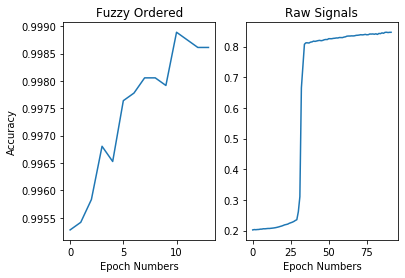

In [52]:
ax = plt.subplot(121)
plt.plot(range(len(histories[1]['accuracy'])),histories[1]['accuracy'])
ax.set_title("Fuzzy Ordered")
plt.xlabel("Epoch Numbers")
plt.ylabel("Accuracy")
ax2 = plt.subplot(122)
plt.plot(range(len(histories[2]['accuracy'])),histories[2]['accuracy'])
ax2.set_title("Raw Signals")
plt.xlabel("Epoch Numbers")

C:\eng_softs\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


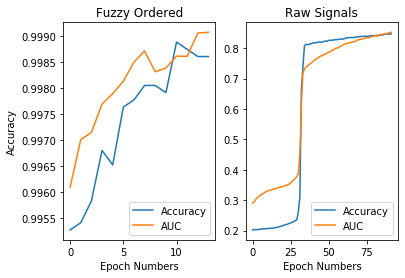

In [54]:
ax = plt.subplot(121)
plt.plot(range(len(histories[1]['accuracy'])),histories[1]['accuracy'])
plt.plot(range(len(histories[1]['AUC'])),histories[1]['AUC'])
ax.set_title("Fuzzy Ordered")
plt.xlabel("Epoch Numbers")
plt.ylabel("Accuracy")
plt.legend(["Accuracy","AUC"])
ax2 = plt.subplot(122)
plt.plot(range(len(histories[2]['accuracy'])),histories[2]['accuracy'])
plt.plot(range(len(histories[2]['AUC'])),histories[2]['AUC'])
ax2.set_title("Raw Signals")
plt.xlabel("Epoch Numbers")
plt.legend(["Accuracy","AUC"])
# Plotting AUC vs Epoch numbers
ax2 = plt.subplot(121)
plt.legend(["Accuracy","AUC"])